In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.patches as patches
% matplotlib inline

In [2]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y*2008*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])

uvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')

vvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')

wvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridW_19692008.nc')

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y19682008.nc']


In [3]:
lonNEMO=ptrc.variables['nav_lon'][:,:]
latNEMO=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy=tmask.variables['mbathy'][0,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]



In [4]:
def vel(keyword,T,ENG):
    'design to obtain velocity field'
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s*.nc'%(ENG,T)))
        uvel=nc.Dataset(nc_filename[0])        
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s*.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

In [5]:
m = Basemap(projection='npstere',boundinglat=67,lon_0=0,resolution='l',round='TRUE')
x_lon,y_lat = m(lonNEMO,latNEMO)



In [6]:
dx=x_lon[1:]-x_lon[:-1]
dz=dep[1:]-dep[:-1]
print (dx.shape,dz.shape)

(399, 544) (49,)


In [52]:
def Fram(time,startyear,ENG):

    v =vel('V',time+startyear,ENG)
    flux=np.empty(v[1:,-265,310:335].shape)
    for i in range(len(dz)):
        flux[i,:]=v[i+1,-265,310:335]*dx[-265,310:335]*dz[i]
    flux =np.ma.masked_where(flux==0,flux)
    plt.pcolor((x_lon[-265,310:335]-x_lon[-265,310])/1000.,dep[1:],v[1:,-265,310:335],\
               cmap=plt.cm.RdBu_r,vmin=-0.05,vmax=0.05);
    plt.colorbar()
    plt.ylim([0,4000])
    plt.gca().invert_yaxis();
    plt.xlabel('x (km)')
    plt.ylabel('depth (m)')

    print ('total flux: %s'%np.sum(flux))

total flux: -1248315.89563


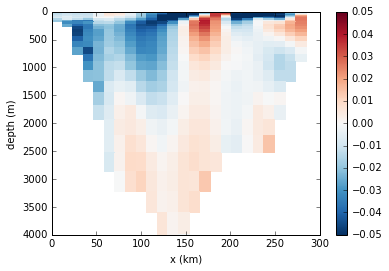

In [53]:
Fram(time=6,startyear=2002,ENG='EXH005')

total flux: -419880.195743


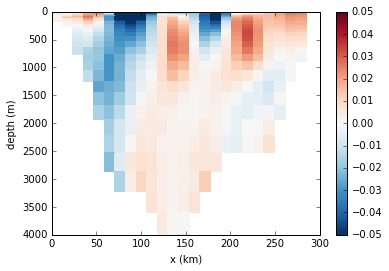

In [54]:
Fram(time=6,startyear=2002,ENG='EXH001')

total flux: -1638488.1679


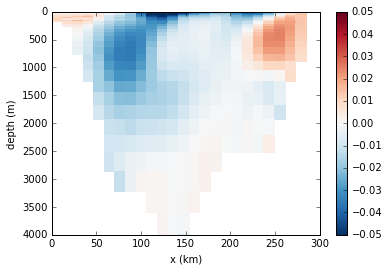

In [55]:
Fram(time=6,startyear=2002,ENG='ENG3')

In [112]:
def BSea(time,startyear,ENG):

    v =vel('V',time+startyear,ENG)
    flux=np.empty((49,24))
    input_lon,input_lat,input_v=[],[],[]
    for i in range (25):
        input_lon.append(x_lonNEMO[-270+2*i,370+2*i])
        input_lat.append(y_latNEMO[-270+2*i,370+2*i])
        input_v.append(v[:,-270+2*i,370+2*i])
    input_lon=np.array(input_lon)
    
    input_dx=input_lon[1:]-input_lon[:-1]
    input_v=np.array(input_v)
 
    for i in range(len(dz)):
        flux[i,:]=input_v[1:,i+1]*input_dx[:]*dz[i]
    flux =np.ma.masked_where(flux==0,flux)

    plt.pcolor(input_dx,dep[1:],input_v[1:,1:].T,\
               cmap=plt.cm.RdBu_r,vmin=-0.05,vmax=0.05);
    plt.colorbar()
    plt.ylim([0,500])
    plt.gca().invert_yaxis();
    plt.xlabel('x (km)')
    plt.ylabel('depth (m)')

    print ('total flux: %.2e'%np.sum(flux))

total flux: 3.44e+06


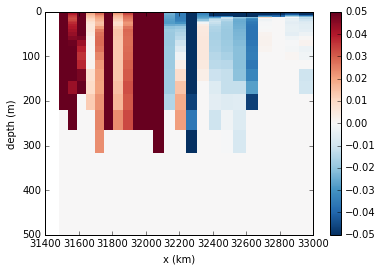

In [113]:
BSea(time=6,startyear=2002,ENG='EXH001')

total flux: 3.03e+06


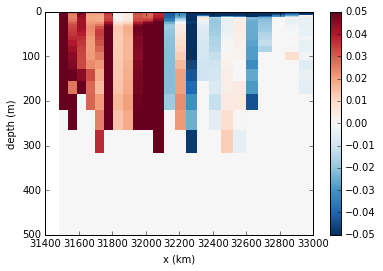

In [114]:
BSea(time=6,startyear=2002,ENG='EXH005')

total flux: 6.93e+06


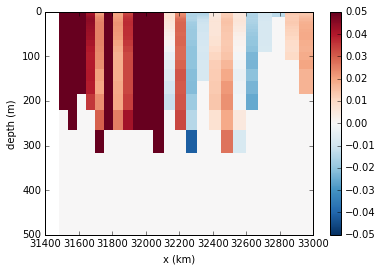

In [115]:
BSea(time=6,startyear=2002,ENG='ENG3')

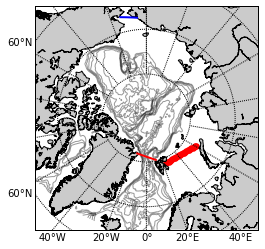

In [19]:
m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')

m.drawcoastlines()
m.fillcontinents(color = '0.75',alpha=0.8)
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

x_lonNEMO,y_latNEMO = m(lonNEMO,latNEMO)
#m.pcolor(x_lonNEMO,y_latNEMO,x_lonNEMO/1000.);m.colorbar()
m.contour(x_lonNEMO,y_latNEMO,bathy,linewidth=0.075,colors='black',alpha=0.4)
m.plot(x_lonNEMO[-20,220:250],y_latNEMO[-20,220:250],lw=2)
m.plot(x_lonNEMO[-270,310:350],y_latNEMO[-270,310:350],lw=2,color='r')
for i in range (25):
    m.scatter(x_lonNEMO[-270+2*i,370+2*i],y_latNEMO[-270+2*i,370+2*i],lw=2,color='r')

In [94]:
def Berling(time,startyear,ENG):

    v =vel('V',time+startyear,ENG)
    flux=np.empty(v[1:,-20,220:250].shape)
    for i in range(len(dz)):
        flux[i,:]=v[i+1,-20,220:250]*dx[-20,220:250]*dz[i]
    flux =np.ma.masked_where(flux==0,flux)
    plt.pcolor((x_lon[-20,220:250]-x_lon[-20,220])/1000.,dep[1:],v[1:,-20,220:250],\
               cmap=plt.cm.RdBu_r,vmin=-0.4,vmax=0.4);
    plt.colorbar()
    plt.ylim([0,60])
    plt.gca().invert_yaxis();
    plt.xlabel('x (km)')
    plt.ylabel('depth (m)')

    print ('total flux: %s'%np.sum(flux))
    print ('mean flux: %s'%np.mean(flux))

total flux: -39069.9728403
mean flux: -94.6004184995


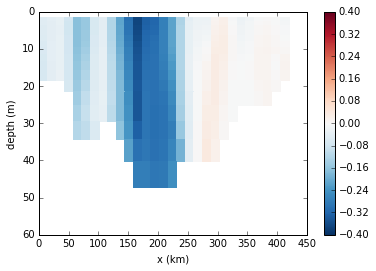

In [95]:
Berling(time=6,startyear=2002,ENG='EXH001')

total flux: -38581.1083717
mean flux: -93.4167272923


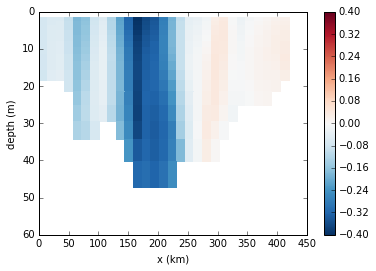

In [96]:
Berling(time=6,startyear=2002,ENG='EXH005')

total flux: -38443.7161739
mean flux: -93.0840585324


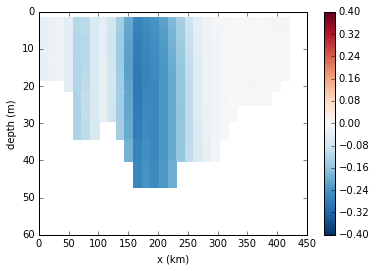

In [97]:
Berling(time=6,startyear=2002,ENG='ENG3')

In [45]:
a=np.array([1,3,4])
a=np.ma.masked_where(a==4,a)
print (a)

[1 3 --]


In [47]:
np.sum(a)

4